<a href="https://colab.research.google.com/github/kiran74-ds/zsl/blob/main/Zero_Shot_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Zero shot learning aims to solve a task to identify classes that are not seen by the model during training.

#### For example, let’s say you have seen a horse but never seen a zebra. If I tell you that a zebra looks like a horse but it has black and white stripes, you will probably immediately recognize a zebra when you see it.

#### This is what zero-shot learning aims to tackle.

#### The high-level strategy we adopt while coding up Zero-shot learning is:
1. Import dataset- which constitutes training images and their corresponding class labels
2. Fetch the word vectors corresponding to each class from pre-trained word vector models.
3. Pass the image through a pre-trained image model like VGG16 and obtain image embedding.
4. We expect the network to predict the word vector corresponding to the object in the image.
5. Once we train the model, predict word vector on new images.
6. The class of word vector that is closest to the predicted word vector is the class of image.

<img src="https://www.learnopencv.com/wp-content/uploads/2020/06/zero-shot-learning-embedding-based-methods.png">


**Train Classes**:
arm, boy, bread, chicken, child, computer, ear, house, leg, sandwich, television, truck, vehicle, watch, woman

**Zero-Shot Classes**:
car, food, hand, man, neck


In [1]:
!git clone https://github.com/kiran74-ds/zsl.git

Cloning into 'zsl'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 31 (delta 4), reused 27 (delta 3), pack-reused 0
Unpacking objects: 100% (31/31), done.


**Import Libraries**

In [2]:
%cd zero-shot-learning/src
import gzip
import _pickle as cPickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, normalize 
from torch.utils.data import TensorDataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/content/zero-shot-learning/src


#### Image Embeddings

Then, image features are extracted from these cropped images using a pre-trained model, VGG16 in our case . Feature extractor class can be seen below.

In [3]:
DATAPATH = "../data/zeroshot_data.pkl"

#### Class Embeddings

Class embedding is the vector representation of a class (class label)

After we have extracted the image features and formed the datasets, now we should gather the other representations of classes, word embeddings namely. We will use Google Word2Vec representation trained on Google News documents. We will get a Wor2Vec of 300 dimensions for each of the 20 object classes we have specified

In [4]:
WORD2VECPATH = "../data/class_vectors.npy" 

In [5]:
with open('train_classes.txt', 'r') as infile: 
  train_classes = [str.strip(line) for line in infile]

In [6]:
with gzip.GzipFile(DATAPATH, 'rb') as infile: 
    data = cPickle.load(infile)
training_data = [instance for instance in data if instance[0] in train_classes]

In [7]:
train_size = 300 # per class
train_data, valid_data = [], [] 
for class_label in train_classes:
  ctr = 0
  for instance in training_data:
    if instance[0] == class_label:
      if ctr < train_size:
          train_data.append(instance)
          ctr+=1 
      else:
          valid_data.append(instance)

**Load the Data** 

In [8]:
def load_data():
  # Load the feature vector data
  with gzip.GzipFile(DATAPATH, 'rb') as infile: 
    data = cPickle.load(infile)

  # Define the training classes and the classes that belong to zero-shot. 
  # Note that, we will only show the classes belonging to training classes and hide the zero-shot model classes until the inference time

  training_data = [instance for instance in data if instance[0] in train_classes]
  zero_shot_data = [instance for instance in data if instance[0] not in train_classes]
  np.random.shuffle(training_data)

  # Fetch 300 training images per class for training and the remaining training class images into validation
  train_size = 300 # per class
  train_data, valid_data = [], [] 
  for class_label in train_classes:
    ctr = 0
    for instance in training_data:
      if instance[0] == class_label:
        if ctr < train_size:
            train_data.append(instance)
            ctr+=1 
        else:
            valid_data.append(instance)

  # Shuffle the training and validation data and fetch the vectors corresponding to the classes into a dictionary 
  np.random.shuffle(train_data)
  np.random.shuffle(valid_data)
  vectors = {i:j for i,j in np.load(WORD2VECPATH, allow_pickle=True)}

  # Fetch the training, validation, and zero-shot classes
  train_clss = [clss for clss,feat in train_data] 
  valid_clss = [clss for clss,feat in valid_data] 
  zero_shot_clss = [clss for clss,feat in zero_shot_data]

  # Fetch the image and word embedding features for training and validation data
  train_data = [(feat, vectors[clss]) for clss,feat in train_data] 
  valid_data = [(feat, vectors[clss]) for clss,feat in valid_data]

  # Define the input and output arrays of training data, validation data, and zero- shot data
  x_train, y_train = zip(*train_data)
  x_train, y_train = np.squeeze(np.asarray(x_train)), np.squeeze(np.asarray(y_train))
  x_train = normalize(x_train, norm='l2')

  x_valid, y_valid = zip(*valid_data)
  x_valid, y_valid = np.squeeze(np.asarray(x_valid)), np.squeeze(np.asarray(y_valid))
  x_valid = normalize(x_valid, norm='l2')

  y_zsl, x_zsl = zip(*zero_shot_data)
  x_zsl, y_zsl = np.squeeze(np.asarray(x_zsl)), np.squeeze(np.asarray(y_zsl))
  x_zsl = normalize(x_zsl, norm='l2')

  # Define the training and validation datasets and dataloaders
  trn_ds = TensorDataset(*[torch.Tensor(t).to(device) for t in [x_train, y_train]])
  val_ds = TensorDataset(*[torch.Tensor(t).to(device) for t in [x_valid, y_valid]])

  trn_dl = DataLoader(trn_ds, batch_size=32, shuffle=True) 
  val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)

  return trn_dl, val_dl, x_zsl, zero_shot_clss, valid_clss, x_valid

**Model Building and Training**

Build a model that takes the 4096-dimensional feature as input and predicts the 300-dimensional vector as output


In [9]:
def build_model(): 
  return nn.Sequential(
      nn.Linear(4096, 1024), 
      nn.ReLU(inplace=True), 
      nn.BatchNorm1d(1024), 
      nn.Dropout(0.8), 
      nn.Linear(1024, 512), 
      nn.ReLU(inplace=True), 
      nn.BatchNorm1d(512), 
      nn.Dropout(0.8), 
      nn.Linear(512, 256), 
      nn.ReLU(inplace=True), 
      nn.BatchNorm1d(256), 
      nn.Dropout(0.8), 
      nn.Linear(256, 300)
)

Functions to train and validate on a batch of data

In [10]:
def train_batch(model, data, optimizer, criterion):
  model.train()
  ims, labels = data
  _preds = model(ims)
  optimizer.zero_grad()
  loss = criterion(_preds, labels)
  loss.backward() 
  optimizer.step() 
  return loss.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
  model.eval()
  ims, labels = data
  _preds = model(ims)
  loss = criterion(_preds, labels) 
  
  return loss.item()

Train the model over increasing epochs

In [11]:
trn_dl, val_dl, x_zsl, zero_shot_clss, valid_clss, x_valid = load_data()
model = build_model().to(device)

print(model)

Sequential(
  (0): Linear(in_features=4096, out_features=1024, bias=True)
  (1): ReLU(inplace=True)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.8, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.8, inplace=False)
  (8): Linear(in_features=512, out_features=256, bias=True)
  (9): ReLU(inplace=True)
  (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.8, inplace=False)
  (12): Linear(in_features=256, out_features=300, bias=True)
)


In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3) 

n_epochs = 65
train_losses, valid_losses = [], []
#log = Report(n_epochs) 
for ex in range(n_epochs):
  N = len(trn_dl)
  running_loss = 0 
  for bx, data in enumerate(trn_dl):
    batch_loss = train_batch(model, data, optimizer, criterion) 
    running_loss += batch_loss *32 
  train_epoch_loss = running_loss / N
  train_losses.append(train_epoch_loss)
    #log.record(ex+(bx+1)/N, trn_loss=loss, end='\r')

  N = len(val_dl)
  running_loss = 0 
  for bx, data in enumerate(val_dl):
    batch_loss = validate_batch(model, data, criterion)
    running_loss += batch_loss *32 
  valid_epoch_loss = running_loss / N
  valid_losses.append(valid_epoch_loss)
    #log.record(ex+(bx+1)/N, val_loss=loss, end='\r')
  print("Epoch {} , training loss {}, valid loss {}".format(ex+1, train_epoch_loss, valid_epoch_loss))

  if ex == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4) 
  if ex == 40: optimizer = optim.Adam(model.parameters(), lr=1e-5) 
  #if not (ex+1)%10: log.report_avgs(ex+1)

#log.plot(log=True)

Epoch 1 , training loss 19.120066272451524, valid loss 0.6701433772736407
Epoch 2 , training loss 1.3871672115427383, valid loss 0.5630186542551568
Epoch 3 , training loss 0.6363185893559287, valid loss 0.5490318701622334
Epoch 4 , training loss 0.6239724666514295, valid loss 0.5400513879796291
Epoch 5 , training loss 0.6247138905187025, valid loss 0.5322176503374222
Epoch 6 , training loss 0.622259498910701, valid loss 0.5161788577729083
Epoch 7 , training loss 0.6281832029633488, valid loss 0.5060342004958619
Epoch 8 , training loss 0.6227631856363716, valid loss 0.49523815132201987
Epoch 9 , training loss 0.625836211316129, valid loss 0.48405677650837187
Epoch 10 , training loss 0.6208950310734147, valid loss 0.4713025391101837
Epoch 11 , training loss 0.6144149705027857, valid loss 0.4671480490806255
Epoch 12 , training loss 0.5516382899690182, valid loss 0.44880952353173115
Epoch 13 , training loss 0.505748468933376, valid loss 0.439536507459397
Epoch 14 , training loss 0.49490499

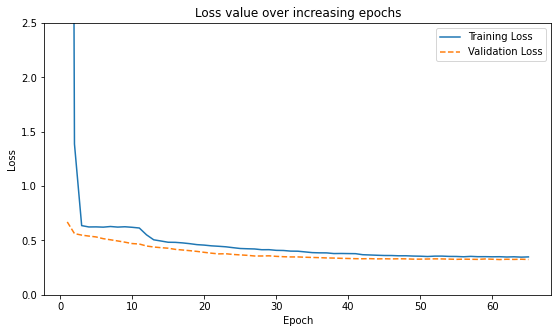

In [19]:
import matplotlib.pyplot as plt
epochs = np.arange(65)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs') 
plt.plot(epochs, train_losses, label='Training Loss') 
plt.plot(epochs, valid_losses, label='Validation Loss', linestyle='dashed') 
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 2.5)
plt.legend();

**Model Evaluation**

Predict on images that contain the zero-shot classes (classes which the model has not seen) and also fetch the actual features and classnames corresponding to the zero-shot classes

In [20]:
pred_zsl = model(torch.Tensor(x_valid).to(device)).cpu().detach().numpy()

class_vectors = sorted(np.load(WORD2VECPATH, allow_pickle=True), key=lambda x: x[0])
classnames, vectors = zip(*class_vectors)
classnames = list(classnames)

vectors = np.array(vectors)

dists = (pred_zsl[None] - vectors[:,None]) 
dists = (dists**2).sum(-1).T

best_classes = []
for item in dists:
  best_classes.append([classnames[j] for j in np.argsort(item)[:5]])

np.mean([i in J for i,J in zip(valid_clss, best_classes)])

0.8814467515070328

In [22]:
pred_zsl = model(torch.Tensor(x_zsl).to(device)).cpu().detach().numpy()

class_vectors = sorted(np.load(WORD2VECPATH, allow_pickle=True), key=lambda x: x[0])
classnames, vectors = zip(*class_vectors)
classnames = list(classnames)

vectors = np.array(vectors)

Calculate the distance between each predicted vector and the vector corresponding to the available classes and measure the number of zero-shot classes present in the top 5 predictions

In [23]:
dists = (pred_zsl[None] - vectors[:,None]) 
dists = (dists**2).sum(-1).T

best_classes = []
for item in dists:
  best_classes.append([classnames[j] for j in np.argsort(item)[:5]])

np.mean([i in J for i,J in zip(zero_shot_clss, best_classes)])

0.7978989494747374

We can predict correctly for ~80% of the images that contain an object whose class is not present during training, in the top 5 predictions of the model.
Note that the percentage of correctly classified images will be 6%, 14%, and 40% for top 1,2,3 predictions, respectively